# Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='notebook_ims/autoencoder_denoise.png' width=70%/>

Let's get started by importing our libraries and getting the dataset.

In [1]:
!pip install -r requirements.txt | grep -v "already"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=1d8e813e7b105262333dfd0589fb1dc83557f4de3adcbc38100badc07414de55
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


> After installing the dependencies you need to restart your kernel, then proceed with the following cells.

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

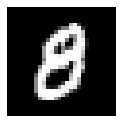

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
# Denoising

As we've mentioned before, autoencoders like the ones you've built so far aren't too useful in practice. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images I generated and the associated, denoised images.

<img src='notebook_ims/denoising.png' />

Below you will write a convolutional autoencoder. Given the difficulty of the task, you might want to add more layers than what we used in the previous exercises in this lesson.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
                
        return self.model(x)


# initialize the NN
model = ConvDenoiser()

---
## Training

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

First let's specify the loss and the optimizer:

In [24]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

And now let's train:

In [25]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training", 
        total=len(data_loaders['train']), 
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
            
            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.93it/s]


Epoch: 1 	Training Loss: 0.010379	Valid Loss: 0.004644


Validating: 100%|█████████████████████████████| 600/600 [00:22<00:00, 26.81it/s]


Epoch: 2 	Training Loss: 0.004172	Valid Loss: 0.003682


Validating: 100%|█████████████████████████████| 600/600 [00:22<00:00, 26.33it/s]


Epoch: 3 	Training Loss: 0.003512	Valid Loss: 0.003845


Validating: 100%|█████████████████████████████| 600/600 [00:24<00:00, 24.19it/s]


Epoch: 4 	Training Loss: 0.003176	Valid Loss: 0.003067


Validating: 100%|█████████████████████████████| 600/600 [00:22<00:00, 26.21it/s]


Epoch: 5 	Training Loss: 0.002945	Valid Loss: 0.002858


Validating: 100%|█████████████████████████████| 600/600 [00:26<00:00, 22.23it/s]


Epoch: 6 	Training Loss: 0.002795	Valid Loss: 0.002791


Validating: 100%|█████████████████████████████| 600/600 [00:26<00:00, 22.64it/s]


Epoch: 7 	Training Loss: 0.002681	Valid Loss: 0.002670


Validating: 100%|█████████████████████████████| 600/600 [00:24<00:00, 24.89it/s]


Epoch: 8 	Training Loss: 0.002597	Valid Loss: 0.002680


Validating: 100%|█████████████████████████████| 600/600 [00:27<00:00, 21.52it/s]


Epoch: 9 	Training Loss: 0.002521	Valid Loss: 0.002527


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.83it/s]


Epoch: 10 	Training Loss: 0.002467	Valid Loss: 0.002439


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 24.00it/s]


Epoch: 11 	Training Loss: 0.002419	Valid Loss: 0.002414


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.16it/s]


Epoch: 12 	Training Loss: 0.002379	Valid Loss: 0.002405


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.10it/s]


Epoch: 13 	Training Loss: 0.002345	Valid Loss: 0.002379


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.44it/s]


Epoch: 14 	Training Loss: 0.002314	Valid Loss: 0.002332


Validating: 100%|█████████████████████████████| 600/600 [00:25<00:00, 23.47it/s]


Epoch: 15 	Training Loss: 0.002288	Valid Loss: 0.002307


Validating: 100%|█████████████████████████████| 600/600 [00:24<00:00, 24.31it/s]


Epoch: 16 	Training Loss: 0.002262	Valid Loss: 0.002307


Validating: 100%|█████████████████████████████| 600/600 [00:26<00:00, 22.83it/s]


Epoch: 17 	Training Loss: 0.002243	Valid Loss: 0.002254


Validating: 100%|█████████████████████████████| 600/600 [00:23<00:00, 25.33it/s]


Epoch: 18 	Training Loss: 0.002219	Valid Loss: 0.002276


Validating: 100%|█████████████████████████████| 600/600 [00:22<00:00, 26.42it/s]


Epoch: 19 	Training Loss: 0.002204	Valid Loss: 0.002254


Validating: 100%|█████████████████████████████| 600/600 [00:24<00:00, 24.21it/s]

Epoch: 20 	Training Loss: 0.002190	Valid Loss: 0.002219


## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

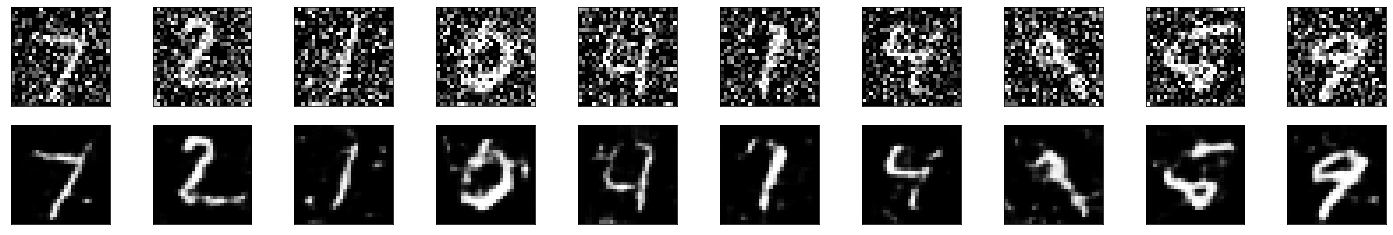

In [27]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)